# Implementing method on CIFAR10 dataset

Starting with loading the dataset - aiming to have a subset of 1 000 imgaes for training 1 000 images for validation and 2 000 images for testing.

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

### Get the data

Shuffling the validation set below

In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the full CIFAR-10 datasets
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def get_balanced_indices(dataset, num_per_class):
    """
    Returns a list of indices such that for each class (0-9) num_per_class indices are chosen.
    """
    # Create a dictionary mapping class label to list of indices
    class_to_indices = {i: [] for i in range(10)}
    for idx, label in enumerate(dataset.targets):
        class_to_indices[label].append(idx)

    balanced_indices = []
    # For each class, shuffle the indices and pick num_per_class indices
    for i in range(10):
        indices = class_to_indices[i]
        np.random.shuffle(indices)
        balanced_indices.extend(indices[:num_per_class]) # Appends num_per_class indices

    return balanced_indices

# For training and validation, we need 200 images per class (split into 100 train + 100 val)
samples_per_class = 400 # same for test and train here
train_val_indices = get_balanced_indices(full_trainset, samples_per_class)  # Total 2000 images

# Now, split the 2000 images into train (first 100 per class) and validation (next 100 per class)
train_indices = []
val_indices = []
# Create a dictionary to collect indices per class from the selected 2000 indices
class_indices = {i: [] for i in range(10)}
for idx in train_val_indices:
    label = full_trainset.targets[idx]
    class_indices[label].append(idx)

# For each class, split indices into 100 for training and 100 for validation
for i in range(10):
    indices = class_indices[i]
    # In case there are less than 200 (should not happen for CIFAR-10), this will take available indices.
    train_indices.extend(indices[:200])
    val_indices.extend(indices[200:400])

# For the test set, select 200 images per class (total 2000 images)
test_indices = get_balanced_indices(full_testset, samples_per_class)

# Create subsets for train, validation, and test
trainset = Subset(full_trainset, train_indices)
valset   = Subset(full_trainset, val_indices)
testset  = Subset(full_testset, test_indices)

# Create DataLoaders
batch_size = 64
num_workers = 2

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)      # NOTE shuffle=True
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print dataset sizes and loader lengths
print("Train set size:", len(trainset))        # Expected 1000
print("Validation set size:", len(valset))       # Expected 1000
print("Test set size:", len(testset))            # Expected 2000
print("Trainloader batches:", len(train_loader))
print("Validationloader batches:", len(val_loader))
print("Testloader batches:", len(test_loader))

# CIFAR-10 class names for reference
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified
Train set size: 2000
Validation set size: 2000
Test set size: 4000
Trainloader batches: 32
Validationloader batches: 32
Testloader batches: 63


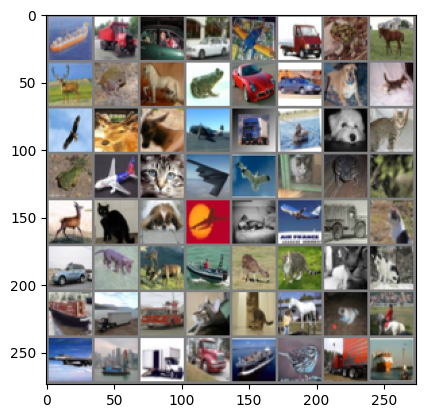

 ship truck   car   car plane truck  frog horse
torch.Size([64, 3, 32, 32])


In [ ]:
#plot some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for inputs, labels in train_loader:
    imshow(torchvision.utils.make_grid(inputs))
    print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))
    print(inputs.shape)
    break

### Fit models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Git_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_f

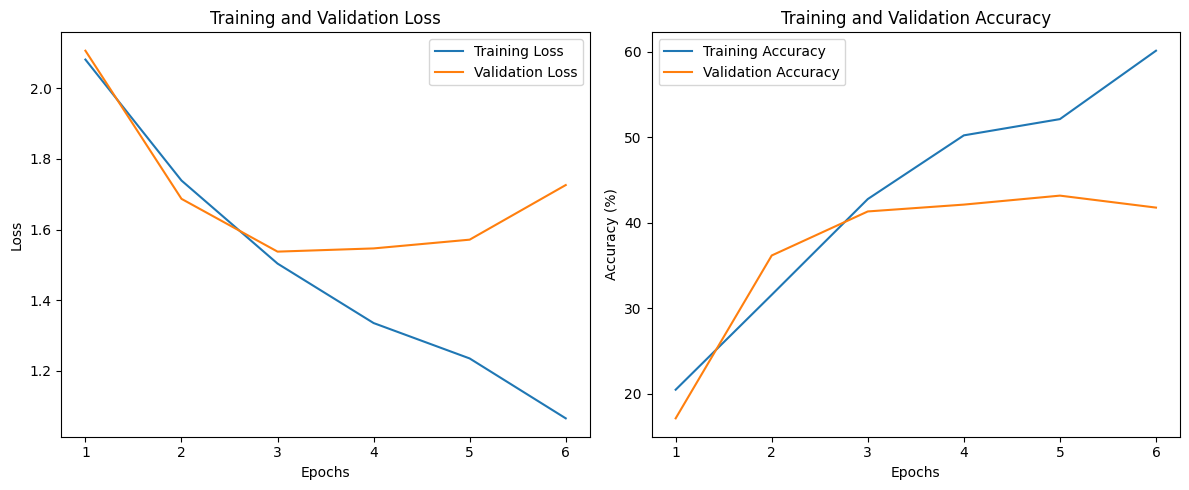

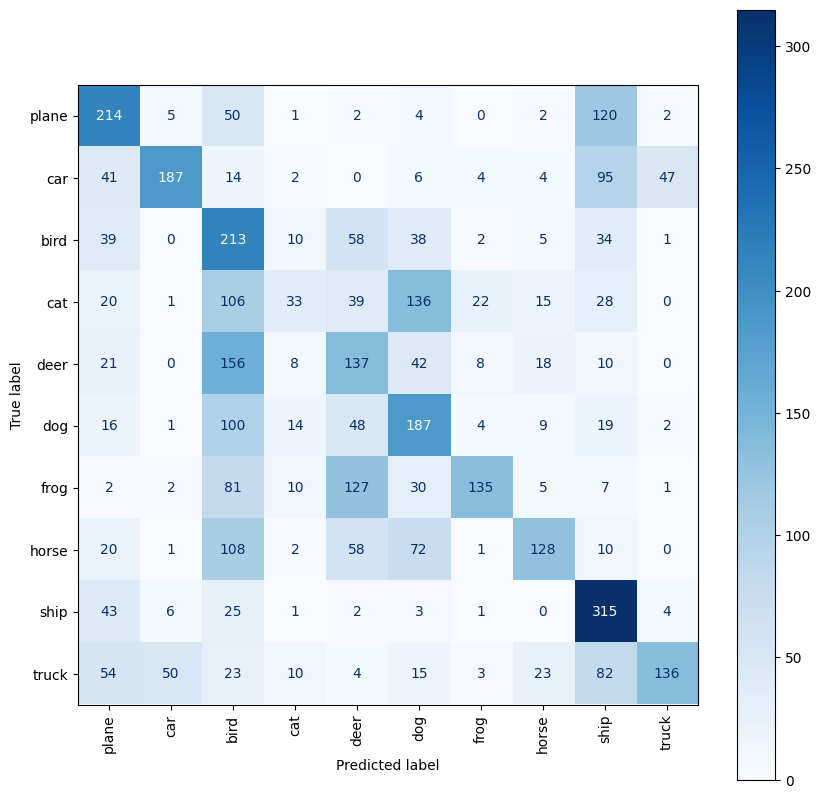

In [ ]:
import sys
# locally
#sys.path.append('../src')

# for colab
from google.colab import drive
drive.mount('/content/drive')

# Append your folder's path to sys.path
sys.path.append('/content/drive/MyDrive/Thesis_REMOVE/')

from members import Git_CNN
from deep_ensemble import DeepEnsemble
from calibrator import Calibrator

from plotting import plot_metrics, plot_confusion_matrix

lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6

# Instantiate model
cnn_member = Git_CNN()
print(cnn_member)
# fit the model

optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)                   #ca 46% val acc 128
#optimizer = torch.optim.SGD(cnn_member.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)   #ca 47 val acc - batch_size = 32
criterion = nn.CrossEntropyLoss()                                                                         #loss fn
train_losses, train_accuracies, val_losses, val_accuracies = cnn_member.train_model(train_loader, val_loader,
                                                                                    criterion = criterion, optimizer = optimizer,
                                                                                    num_epochs=num_epochs, patience=patience, min_delta=min_delta)

print("Train accuracy: ", train_accuracies[-1])
print("Validation accuracy: ", val_accuracies[-1])


plot_metrics(train_losses, val_losses, train_accuracies,  val_accuracies, len(train_losses))
plot_confusion_matrix(cnn_member, test_loader, class_names=class_names)

DeepEnsemble(
  (models): ModuleList(
    (0-4): 5 x Git_CNN(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=64

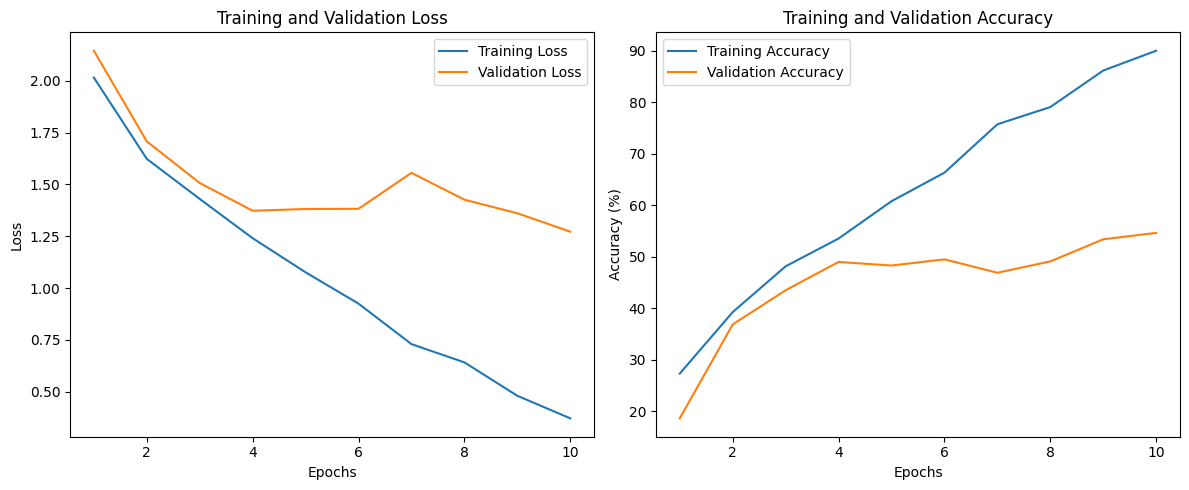

Validation accuracy:  54.65


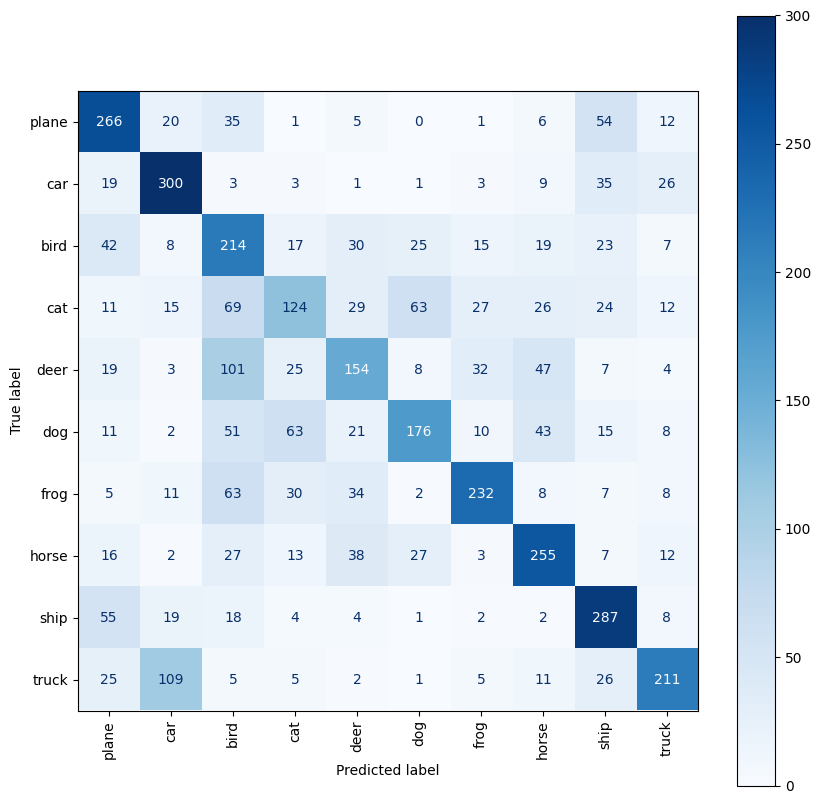

In [ ]:
epsilon = 0.1

ensemble_model = DeepEnsemble(num_models=5, model_class=Git_CNN, lr = lr, weight_decay=weight_decay
                              ) #no model kwargs needed
print(ensemble_model)

de_train_results = ensemble_model.train_model(train_loader, val_loader, criterion, num_epochs, epsilon, adversarial_training=False,    # NOTE false
                                        patience=5, min_delta=1e-6)
#plot the results
plot_metrics(de_train_results['train_losses'], de_train_results['val_losses'],
             de_train_results['train_accuracies'],  de_train_results['val_accuracies'], len(de_train_results['train_losses']))
print("Validation accuracy: ", de_train_results['val_accuracies'][-1])
plot_confusion_matrix(ensemble_model, test_loader, class_names=class_names)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


c2_vals = np.linspace(1, 2, 10)
c1_vals = np.linspace(0.5, 1.5, 11)
epi_scalar_vals = np.array([1])

calibrator = Calibrator(ensemble_model, adjusting_alpha_method="convex_comb_global",
                                clamping_alphas= False, logits_based_adjustments= True) # this flag does not matter for pure_logits

# Time: 50 sec
_, best_param_gs = calibrator.grid_search_c1_c2(val_loader=val_loader, c1_vals=c1_vals,
                                                                       c2_vals=c2_vals, epi_scalar_vals= epi_scalar_vals)

print(f"Best results (Grid Search): c1={best_param_gs['c1']}",
      f"c2={best_param_gs['c2']}", f"epi_scalar={best_param_gs['epi_scalar']}",
      f"nll in validation set={best_param_gs['nll_val']}")

# Time: 2 sec
_, best_param_gsp = calibrator.grid_search_c1_c2_precomputed(val_loader=val_loader, c1_vals=c1_vals,
                                                                       c2_vals=c2_vals, epi_scalar_vals= epi_scalar_vals)

print(f"Best results (Grid Search): c1={best_param_gsp['c1']}",
      f"c2={best_param_gsp['c2']}", f"epi_scalar={best_param_gsp['epi_scalar']}",
      f"nll in validation set={best_param_gsp['nll_val']}")



Best results (Grid Search): c1=0.5 c2=1.0 epi_scalar=1 nll in validation set=2.3025851249694824
Best results (Grid Search): c1=0.5 c2=1.0 epi_scalar=1 nll in validation set=2.3025853633880615


## Full pipeline  for experiments

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{0.25}_{0.25}_{0.5}_{batch_size}"

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = Git_CNN()
    optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)

    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=Git_CNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)
# save the results
#df_results_no_AT.to_csv("Binary_results_no_AT.csv", index=False)

print("\nFinal Results DataFrame:")
df_results_no_AT = df_results_no_AT.sort_values(by=["SEED", "NLL Test"])
df_results_no_AT



=== Running experiment with MODEL SEED = 25 ===
Early stopping triggered at epoch 4.
Early stopping triggered for model 0 at epoch 5.
Early stopping triggered for model 2 at epoch 5.
Early stopping triggered for model 4 at epoch 5.
Early stopping triggered for model 1 at epoch 10.
Early stopping triggered for model 3 at epoch 10.
All models have stopped early. Ending training.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.0363636363636364, 'c2': 1.0, 'epi_scalar': 1, 'nll_val': 1.338356614112854}
Calibrating using method: convex_comb
Best parameters: {'c1': 1.0363636363636364, 'c2': 0.0, 'epi_scalar': 1, 'nll_val': 1.3383564949035645}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 1.0363636363636364, 'c2': 0.0, 'epi_scalar': 1, 'nll_val': 1.338356614112854}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 1.0363636363636364, 'c2': 0.0, 'epi_scalar': 1, 'nll_val': 1.338356614112854}

=== Running experiment with MODEL SEED = 26

,SEED,Split,Model,C1,C2,Epi Scalar,Epsilon,NLL Val,NLL Test
1,25,0.25_0.25_0.5_64,DeepEnsemble,NaN,NaN,NaN,0.0,1.338668,1.333920
2,25,0.25_0.25_0.5_64,Calibrator_pure_logits,1.036364,1.000000,1.0,0.0,1.338357,1.334389
3,25,0.25_0.25_0.5_64,Calibrator_convex_comb,1.036364,0.000000,1.0,0.0,1.338356,1.334391
4,25,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.036364,0.000000,1.0,0.0,1.338356,1.334391
5,25,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.036364,0.000000,1.0,0.0,1.338357,1.334391
0,25,0.25_0.25_0.5_64,Simple NN,NaN,NaN,NaN,NaN,2.317315,2.315925
8,26,0.25_0.25_0.5_64,Calibrator_pure_logits,1.109091,1.000000,1.0,0.0,1.317417,1.311608
9,26,0.25_0.25_0.5_64,Calibrator_convex_comb,1.109091,0.000000,1.0,0.0,1.317418,1.311610
10,26,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.109091,0.000000,1.0,0.0,1.317418,1.311610
11,26,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.109091,0.000000,1.0,0.0,1.317418,1.311610


In [ ]:
#save results
from google.colab import files
df_results_no_AT.to_csv('CIFAR_results_NO_AT_25_35.csv', index=False)
files.download('CIFAR_results_NO_AT_25_35.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6

optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{0.25}_{0.25}_{0.5}_{batch_size}"

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = Git_CNN()
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=Git_CNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE True
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)
# save the results
#df_results_no_AT.to_csv("Binary_results_no_AT.csv", index=False)

print("\nFinal Results DataFrame:")
df_results_no_AT = df_results_no_AT.sort_values(by=["SEED", "NLL Test"])
df_results_no_AT



=== Running experiment with MODEL SEED = 25 ===
Early stopping triggered at epoch 4.
Early stopping triggered for model 1 at epoch 8.
Early stopping triggered for model 0 at epoch 10.
Early stopping triggered for model 2 at epoch 10.
Early stopping triggered for model 4 at epoch 10.
Early stopping triggered for model 3 at epoch 11.
All models have stopped early. Ending training.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.218181818181818, 'c2': 1.0, 'epi_scalar': 1, 'nll_val': 1.2945327758789062}
Calibrating using method: convex_comb
Best parameters: {'c1': 1.1818181818181819, 'c2': 0.10101010101010102, 'epi_scalar': 1, 'nll_val': 1.292983889579773}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 1.1636363636363636, 'c2': 0.12121212121212122, 'epi_scalar': 1, 'nll_val': 1.292988657951355}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 1.1636363636363636, 'c2': 0.12121212121212122, 'epi_scalar': 1, 'nll_val': 1.293168783187

,SEED,Split,Model,C1,C2,Epi Scalar,Epsilon,NLL Val,NLL Test
2,25,0.25_0.25_0.5_64,Calibrator_pure_logits,1.218182,1.000000,1.0,0.1,1.294533,1.264326
5,25,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.163636,0.121212,1.0,0.1,1.293169,1.264580
4,25,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.163636,0.121212,1.0,0.1,1.292989,1.264599
3,25,0.25_0.25_0.5_64,Calibrator_convex_comb,1.181818,0.101010,1.0,0.1,1.292984,1.264885
1,25,0.25_0.25_0.5_64,DeepEnsemble,NaN,NaN,NaN,0.1,1.307377,1.265505
0,25,0.25_0.25_0.5_64,Simple NN,NaN,NaN,NaN,NaN,2.317315,2.315925
9,26,0.25_0.25_0.5_64,Calibrator_convex_comb,1.181818,0.131313,1.0,0.1,1.393805,1.410912
10,26,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.181818,0.151515,1.0,0.1,1.393860,1.410955
11,26,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.200000,0.090909,1.0,0.1,1.394527,1.411021
8,26,0.25_0.25_0.5_64,Calibrator_pure_logits,1.236364,1.000000,1.0,0.1,1.394916,1.411476


In [ ]:
#save results
from google.colab import files
df_results_no_AT.to_csv('CIFAR_results_AT_25_35.csv', index=False)
files.download('CIFAR_results_AT_25_35.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Same pipeline but without early stoppage

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
# Based of earlier early stoppage
num_epochs = 10
patience = 3
min_delta = 1e-6

optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{0.25}_{0.25}_{0.5}_{batch_size}"

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = Git_CNN()
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping = False,
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=Git_CNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping = False,
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 5, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 3, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)
# save the results
#df_results_no_AT.to_csv("Binary_results_no_AT.csv", index=False)

print("\nFinal Results DataFrame:")
df_results_no_AT = df_results_no_AT.sort_values(by=["SEED", "NLL Test"])
df_results_no_AT



=== Running experiment with MODEL SEED = 25 ===
Training completed after 10 epochs.
All models have stopped. Ending training at epoch9.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.3454545454545455, 'c2': 1.0, 'epi_scalar': 1, 'nll_val': 1.2832282781600952}
Calibrating using method: convex_comb
Best parameters: {'c1': 1.3272727272727272, 'c2': 0.030303030303030304, 'epi_scalar': 1, 'nll_val': 1.282620906829834}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 1.309090909090909, 'c2': 0.050505050505050504, 'epi_scalar': 1, 'nll_val': 1.2828634977340698}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 1.3272727272727272, 'c2': 0.030303030303030304, 'epi_scalar': 1, 'nll_val': 1.2826061248779297}

=== Running experiment with MODEL SEED = 26 ===
Training completed after 10 epochs.
All models have stopped. Ending training at epoch9.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.3818181818181816, 'c2': 1.0, 'epi_s

,SEED,Split,Model,C1,C2,Epi Scalar,Epsilon,NLL Val,NLL Test
5,25,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.327273,0.030303,1.0,0.0,1.282606,1.293849
3,25,0.25_0.25_0.5_64,Calibrator_convex_comb,1.327273,0.030303,1.0,0.0,1.282621,1.293905
2,25,0.25_0.25_0.5_64,Calibrator_pure_logits,1.345455,1.000000,1.0,0.0,1.283228,1.294125
4,25,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.309091,0.050505,1.0,0.0,1.282863,1.294137
1,25,0.25_0.25_0.5_64,DeepEnsemble,NaN,NaN,NaN,0.0,1.308979,1.321303
0,25,0.25_0.25_0.5_64,Simple NN,NaN,NaN,NaN,NaN,2.317397,2.316043
8,26,0.25_0.25_0.5_64,Calibrator_pure_logits,1.381818,1.000000,1.0,0.0,1.290802,1.294266
9,26,0.25_0.25_0.5_64,Calibrator_convex_comb,1.381818,0.000000,1.0,0.0,1.290804,1.294266
10,26,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.381818,0.000000,1.0,0.0,1.290804,1.294266
11,26,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.381818,0.000000,1.0,0.0,1.290804,1.294266


In [ ]:
#save results
from google.colab import files
df_results_no_AT.to_csv('CIFAR_results_no_AT_noES_25_35.csv', index=False)
files.download('CIFAR_results_no_AT_noES_25_35.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_seeds = 10

# some duplicates
lr = 1e-3
weight_decay = 5e-4
# Based of earlier early stoppage
num_epochs = 10
patience = 3
min_delta = 1e-6

optimizer = torch.optim.Adam(cnn_member.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{0.25}_{0.25}_{0.5}_{batch_size}"

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    cnn_member = Git_CNN()
    _ = cnn_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping = False,
                               patience=patience, min_delta=min_delta)

    cnn_val = cnn_member.predict(val_loader)
    cnn_test = cnn_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(cnn_val['nll']),
        "NLL Test": np.mean(cnn_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=Git_CNN, lr = lr, weight_decay=weight_decay)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE True
                                  early_stopping = False,
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 5, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 3, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)
# save the results
#df_results_no_AT.to_csv("Binary_results_no_AT.csv", index=False)

print("\nFinal Results DataFrame:")
df_results_no_AT = df_results_no_AT.sort_values(by=["SEED", "NLL Test"])
df_results_no_AT



=== Running experiment with MODEL SEED = 25 ===
Training completed after 10 epochs.
All models have stopped. Ending training at epoch9.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.3454545454545455, 'c2': 1.0, 'epi_scalar': 1, 'nll_val': 1.3136956691741943}
Calibrating using method: convex_comb
Best parameters: {'c1': 1.309090909090909, 'c2': 0.09090909090909091, 'epi_scalar': 1, 'nll_val': 1.312957525253296}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 1.309090909090909, 'c2': 0.10101010101010101, 'epi_scalar': 1, 'nll_val': 1.3129661083221436}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 1.309090909090909, 'c2': 0.08080808080808081, 'epi_scalar': 1, 'nll_val': 1.3130532503128052}

=== Running experiment with MODEL SEED = 26 ===
Training completed after 10 epochs.
All models have stopped. Ending training at epoch9.
Calibrating using method: pure_logits
Best parameters: {'c1': 1.309090909090909, 'c2': 1.0, 'epi_scalar'

,SEED,Split,Model,C1,C2,Epi Scalar,Epsilon,NLL Val,NLL Test
3,25,0.25_0.25_0.5_64,Calibrator_convex_comb,1.309091,0.090909,1.0,0.1,1.312958,1.308168
4,25,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.309091,0.101010,1.0,0.1,1.312966,1.308219
5,25,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.309091,0.080808,1.0,0.1,1.313053,1.308470
2,25,0.25_0.25_0.5_64,Calibrator_pure_logits,1.345455,1.000000,1.0,0.1,1.313696,1.309832
1,25,0.25_0.25_0.5_64,DeepEnsemble,NaN,NaN,NaN,0.1,1.341436,1.333169
0,25,0.25_0.25_0.5_64,Simple NN,NaN,NaN,NaN,NaN,2.317397,2.316043
9,26,0.25_0.25_0.5_64,Calibrator_convex_comb,1.290909,0.030303,1.0,0.1,1.334739,1.331458
10,26,0.25_0.25_0.5_64,Calibrator_convex_comb_no_exp,1.309091,0.000000,1.0,0.1,1.334792,1.331499
8,26,0.25_0.25_0.5_64,Calibrator_pure_logits,1.309091,1.000000,1.0,0.1,1.334791,1.331499
11,26,0.25_0.25_0.5_64,Calibrator_convex_comb_global,1.309091,0.010101,1.0,0.1,1.334779,1.331522


In [ ]:
#save results
from google.colab import files
df_results_no_AT.to_csv('CIFAR_results_AT_noES_25_35.csv', index=False)
files.download('CIFAR_results_AT_noES_25_35.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>